> [data.csv] : https://www.kaggle.com/carrie1/ecommerce-data

# 이커머스 고객 군집화 분석

## 분석 프로세스
- 데이터 확인
- 데이터 전처리(결측치, 중복값, 마이닝, 타겟데이터 생성(키워드 생성))
- 모델 생성(k-means 클러스터링, pca, 분류 알고리즘)
- 모델 평가
- 분석
> 군집화된 고객군 분류 예측 모델링

### 1. 데이터 로드 및 탐색

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# from matplotlib import pyplot as plt
# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [3]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [5]:
# !unzip /content/drive/MyDrive/ML_Practice/06_customer_segmentation_ml/archive.zip

In [6]:
# import shutil
# shutil.move('/content/data.csv','/content/drive/MyDrive/ML_Practice/06_customer_segmentation_ml')

In [7]:
df = pd.read_csv('/content/drive/MyDrive/ML_Practice/06_customer_segmentation_ml/data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (541909, 8)


In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Description : 제품 정보

Quantity : 수량

StockCode : 재고 코드

InvoiceNo : 송장 번호


#### 1) StockCode 확인

In [9]:
# StockCode에서 알파벳이 있는 항목 확인
SC_alpha = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
SC_alpha

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [10]:
for code in SC_alpha:
  print(f'{code:>20}')
  display(df[df['StockCode']==code].head(5))
  print('------'*10)

                POST


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.0,12583,France
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.0,12791,Netherlands
1123,536527,POST,POSTAGE,1,12/1/2010 13:04,18.0,12662,Germany
5073,536840,POST,POSTAGE,1,12/2/2010 18:27,18.0,12738,Germany
5258,536852,POST,POSTAGE,1,12/3/2010 9:51,18.0,12686,France


------------------------------------------------------------
                   D


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
9038,C537164,D,Discount,-1,12/5/2010 13:21,29.29,14527,United Kingdom
14498,C537597,D,Discount,-1,12/7/2010 12:34,281.00,15498,United Kingdom
19392,C537857,D,Discount,-1,12/8/2010 16:00,267.12,17340,United Kingdom
31134,C538897,D,Discount,-1,12/15/2010 9:14,5.76,16422,United Kingdom


------------------------------------------------------------
                  C2


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1423,536540,C2,CARRIAGE,1,12/1/2010 14:05,50.0,14911,EIRE
12119,537368,C2,CARRIAGE,1,12/6/2010 12:40,50.0,14911,EIRE
12452,537378,C2,CARRIAGE,1,12/6/2010 13:06,50.0,14911,EIRE
19975,537963,C2,CARRIAGE,1,12/9/2010 11:30,50.0,13369,United Kingdom
20016,538002,C2,CARRIAGE,1,12/9/2010 11:48,50.0,14932,Channel Islands


------------------------------------------------------------
                 DOT


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1814,536544,DOT,DOTCOM POSTAGE,1,12/1/2010 14:32,569.77,NaN,United Kingdom
3041,536592,DOT,DOTCOM POSTAGE,1,12/1/2010 17:06,607.49,NaN,United Kingdom
5450,536862,DOT,DOTCOM POSTAGE,1,12/3/2010 11:13,254.43,NaN,United Kingdom
5545,536864,DOT,DOTCOM POSTAGE,1,12/3/2010 11:27,121.06,NaN,United Kingdom
5685,536865,DOT,DOTCOM POSTAGE,1,12/3/2010 11:28,498.47,NaN,United Kingdom


------------------------------------------------------------
                   M


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,12/1/2010 15:35,1.25,16274,United Kingdom
2250,536569,M,Manual,1,12/1/2010 15:35,18.95,16274,United Kingdom
5684,536865,M,Manual,1,12/3/2010 11:28,2.55,NaN,United Kingdom
6798,536981,M,Manual,2,12/3/2010 14:26,0.85,14723,United Kingdom
7976,537077,M,Manual,12,12/5/2010 11:59,0.42,17062,United Kingdom


------------------------------------------------------------
        BANK CHARGES


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4406,536779,BANK CHARGES,Bank Charges,1,12/2/2010 15:08,15.00,15823,United Kingdom
14435,C537572,BANK CHARGES,Bank Charges,-1,12/7/2010 12:00,95.38,NaN,United Kingdom
28992,C538680,BANK CHARGES,Bank Charges,-1,12/13/2010 17:10,966.92,NaN,United Kingdom
62508,541505,BANK CHARGES,Bank Charges,1,1/18/2011 15:58,15.00,15939,United Kingdom
64573,C541653,BANK CHARGES,Bank Charges,-1,1/20/2011 11:50,1050.15,NaN,United Kingdom


------------------------------------------------------------
                   S


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
14436,C537581,S,SAMPLES,-1,12/7/2010 12:03,12.95,NaN,United Kingdom
14437,C537581,S,SAMPLES,-1,12/7/2010 12:03,52.00,NaN,United Kingdom
96680,C544580,S,SAMPLES,-1,2/21/2011 14:25,5.74,NaN,United Kingdom
96681,C544580,S,SAMPLES,-1,2/21/2011 14:25,11.08,NaN,United Kingdom
96682,C544580,S,SAMPLES,-1,2/21/2011 14:25,5.79,NaN,United Kingdom


------------------------------------------------------------
           AMAZONFEE


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
14514,C537600,AMAZONFEE,AMAZON FEE,-1,12/7/2010 12:41,1.00,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:04,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:34,13474.79,NaN,United Kingdom
16313,C537647,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:41,5519.25,NaN,United Kingdom


------------------------------------------------------------
            DCGS0076


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
21326,538071,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,12/9/2010 14:09,16.13,NaN,United Kingdom
39313,539631,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,2,12/20/2010 15:03,16.13,NaN,United Kingdom


------------------------------------------------------------
            DCGS0003


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
24906,538349,DCGS0003,BOXED GLASS ASHTRAY,1,12/10/2010 14:59,2.51,NaN,United Kingdom
36460,539451,DCGS0003,BOXED GLASS ASHTRAY,1,12/17/2010 16:59,2.51,NaN,United Kingdom
76251,542622,DCGS0003,BOXED GLASS ASHTRAY,1,1/31/2011 9:09,2.46,NaN,United Kingdom
176006,551995,DCGS0003,BOXED GLASS ASHTRAY,1,5/5/2011 15:42,2.46,NaN,United Kingdom
279258,561256,DCGS0003,ebay,-7,7/26/2011 11:53,0.00,NaN,United Kingdom


------------------------------------------------------------
        gift_0001_40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
38248,539492,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,12/20/2010 10:14,34.04,NaN,United Kingdom
145463,548893,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,4/4/2011 15:54,33.33,NaN,United Kingdom
281008,561513,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,7/27/2011 15:12,33.33,NaN,United Kingdom


------------------------------------------------------------
            DCGS0070


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
40052,539718,DCGS0070,CAMOUFLAGE DOG COLLAR,1,12/21/2010 13:06,12.72,NaN,United Kingdom
279253,561251,DCGS0070,NaN,-8,7/26/2011 11:51,0.00,NaN,United Kingdom


------------------------------------------------------------
                   m


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
40383,539736,m,Manual,1,12/21/2010 15:18,2.55,NaN,United Kingdom


------------------------------------------------------------
        gift_0001_50


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
42057,539958,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,12/23/2010 13:26,42.55,NaN,United Kingdom
178556,552232,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,5/6/2011 15:54,41.67,NaN,United Kingdom
239744,558066,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,6/24/2011 15:45,41.67,NaN,United Kingdom
245516,558614,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,6/30/2011 15:56,41.67,NaN,United Kingdom


------------------------------------------------------------
        gift_0001_30


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
44725,540238,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,1/5/2011 14:44,25.53,NaN,United Kingdom
94054,544323,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2/17/2011 15:51,25.00,NaN,United Kingdom
95034,544434,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2/18/2011 16:12,25.00,NaN,United Kingdom
208808,555149,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,5/31/2011 15:49,25.00,NaN,United Kingdom
297099,562933,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,8/10/2011 16:51,25.00,NaN,United Kingdom


------------------------------------------------------------
        gift_0001_20


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
44794,540238,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,1/5/2011 14:44,17.02,NaN,United Kingdom
55589,540995,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,1/13/2011 9:30,16.67,NaN,United Kingdom
91278,544089,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2/15/2011 17:51,16.67,NaN,United Kingdom
161388,550474,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,2,4/18/2011 13:58,16.67,NaN,United Kingdom
163440,550542,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,4/19/2011 11:37,16.67,NaN,United Kingdom


------------------------------------------------------------
            DCGS0055


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
74825,542529,DCGS0055,NaN,-1,1/28/2011 13:08,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGS0072


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
74838,542531,DCGS0072,NaN,-1,1/28/2011 13:08,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGS0074


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
74839,542532,DCGS0074,NaN,-1,1/28/2011 13:09,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGS0069


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
75053,542541,DCGS0069,OOH LA LA DOGS COLLAR,1,1/28/2011 14:25,15.79,NaN,United Kingdom
279254,561252,DCGS0069,ebay,-5,7/26/2011 11:52,0.00,NaN,United Kingdom


------------------------------------------------------------
            DCGS0057


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
75295,542582,DCGS0057,NaN,-6,1/28/2011 15:01,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGSSBOY


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2/7/2011 14:04,3.29,NaN,United Kingdom
97246,544599,DCGSSBOY,BOYS PARTY BAG,1,2/21/2011 18:15,3.29,NaN,United Kingdom
112723,545897,DCGSSBOY,BOYS PARTY BAG,5,3/7/2011 17:22,3.29,NaN,United Kingdom
116891,546306,DCGSSBOY,BOYS PARTY BAG,1,3/10/2011 16:16,3.29,NaN,United Kingdom
128107,547249,DCGSSBOY,BOYS PARTY BAG,6,3/22/2011 9:27,3.29,NaN,United Kingdom


------------------------------------------------------------
           DCGSSGIRL


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2/7/2011 14:04,3.29,NaN,United Kingdom
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,3/7/2011 17:22,3.29,NaN,United Kingdom
116892,546306,DCGSSGIRL,GIRLS PARTY BAG,2,3/10/2011 16:16,3.29,NaN,United Kingdom
128108,547249,DCGSSGIRL,GIRLS PARTY BAG,17,3/22/2011 9:27,3.29,NaN,United Kingdom
128269,547250,DCGSSGIRL,GIRLS PARTY BAG,2,3/22/2011 9:30,3.29,NaN,United Kingdom


------------------------------------------------------------
        gift_0001_10


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
112442,545895,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,3/7/2011 17:14,8.33,NaN,United Kingdom
163439,550542,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,4/19/2011 11:37,8.33,NaN,United Kingdom
191910,553387,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,5/16/2011 16:33,8.33,NaN,United Kingdom
192071,553389,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,5/16/2011 16:37,8.33,NaN,United Kingdom
245515,558614,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,6/30/2011 15:56,8.33,NaN,United Kingdom


------------------------------------------------------------
                PADS


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,4/15/2011 9:27,0.001,13952,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,7/26/2011 10:13,0.001,15618,United Kingdom
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,9/25/2011 12:22,0.000,16133,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,9/25/2011 14:58,0.001,16198,United Kingdom


------------------------------------------------------------
            DCGS0004


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
170783,551340,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,4/27/2011 17:23,16.63,NaN,United Kingdom


------------------------------------------------------------
            DCGS0073


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
279251,561249,DCGS0073,ebay,-4,7/26/2011 11:51,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGS0071


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
279252,561250,DCGS0071,NaN,-2,7/26/2011 11:51,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGS0068


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
279255,561253,DCGS0068,ebay,-10,7/26/2011 11:52,0.0,NaN,United Kingdom


------------------------------------------------------------
            DCGS0067


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
279256,561254,DCGS0067,ebay,-11,7/26/2011 11:52,0.0,NaN,United Kingdom


------------------------------------------------------------
           DCGS0066P


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
279257,561255,DCGS0066P,NaN,-3,7/26/2011 11:52,0.0,NaN,United Kingdom


------------------------------------------------------------
                   B


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


------------------------------------------------------------
                CRUK


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
317508,C564763,CRUK,CRUK Commission,-1,8/30/2011 10:49,1.60,14096,United Kingdom
324023,C565382,CRUK,CRUK Commission,-1,9/2/2011 15:45,13.01,14096,United Kingdom
333779,C566216,CRUK,CRUK Commission,-1,9/9/2011 15:17,15.96,14096,United Kingdom
338848,C566565,CRUK,CRUK Commission,-1,9/13/2011 12:32,52.24,14096,United Kingdom
351003,C567655,CRUK,CRUK Commission,-1,9/21/2011 14:40,608.66,14096,United Kingdom


------------------------------------------------------------


> D랑 CRUK의 경우에만 CustomerID가 NaN이 아니더라도 Quantity가 -1(음수)값을 보임
>
> D는 Discount를 의미함, D의 경우 주문 취소가 불가능
>
> CRUK은 수수료..?

#### 2) InvoiceNo 확인


In [11]:
IN_alpha = df[df['InvoiceNo'].str.contains('^[a-zA-Z]+', regex=True)]['InvoiceNo'].unique()
IN_alpha

array(['C536379', 'C536383', 'C536391', ..., 'C581499', 'C581568',
       'C581569'], dtype=object)

In [12]:
for no in IN_alpha[:10]:
  display(df[df['InvoiceNo']== no])
  print('----'*20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.5,14527,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,12/1/2010 10:24,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,12/1/2010 10:24,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,12/1/2010 10:24,1.65,17548,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
939,C536506,22960,JAM MAKING SET WITH JARS,-6,12/1/2010 12:38,4.25,17897,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1441,C536543,22632,HAND WARMER RED RETROSPOT,-1,12/1/2010 14:30,2.10,17841,United Kingdom
1442,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,12/1/2010 14:30,0.85,17841,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,12/1/2010 14:33,1.95,12472,Germany
1974,C536548,22242,5 HOOK HANGER MAGIC TOADSTOOL,-5,12/1/2010 14:33,1.65,12472,Germany
1975,C536548,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-1,12/1/2010 14:33,2.95,12472,Germany
1976,C536548,22892,SET OF SALT AND PEPPER TOADSTOOLS,-7,12/1/2010 14:33,1.25,12472,Germany
1977,C536548,22654,DELUXE SEWING KIT,-1,12/1/2010 14:33,5.95,12472,Germany
1978,C536548,22767,TRIPLE PHOTO FRAME CORNICE,-2,12/1/2010 14:33,9.95,12472,Germany
1979,C536548,22333,RETROSPOT PARTY BAG + STICKER SET,-1,12/1/2010 14:33,1.65,12472,Germany
1980,C536548,22245,"HOOK, 1 HANGER ,MAGIC GARDEN",-2,12/1/2010 14:33,0.85,12472,Germany
1981,C536548,22077,6 RIBBONS RUSTIC CHARM,-6,12/1/2010 14:33,1.65,12472,Germany
1982,C536548,22631,CIRCUS PARADE LUNCH BOX,-1,12/1/2010 14:33,1.95,12472,Germany


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3170,C536606,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-2,12/2/2010 9:10,2.95,14092,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3338,C536622,22752,SET 7 BABUSHKA NESTING BOXES,-2,12/2/2010 10:37,8.5,12471,Germany


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3410,C536625,22839,3 TIER CAKE TIN GREEN AND CREAM,-2,12/2/2010 10:46,14.95,14766,United Kingdom


--------------------------------------------------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3693,C536642,21463,MIRRORED DISCO BALL,-1,12/2/2010 11:56,5.95,14390,United Kingdom


--------------------------------------------------------------------------------


> C가 포함된 데이터는 주문이 취소된 경우

#### 3) Description 확인

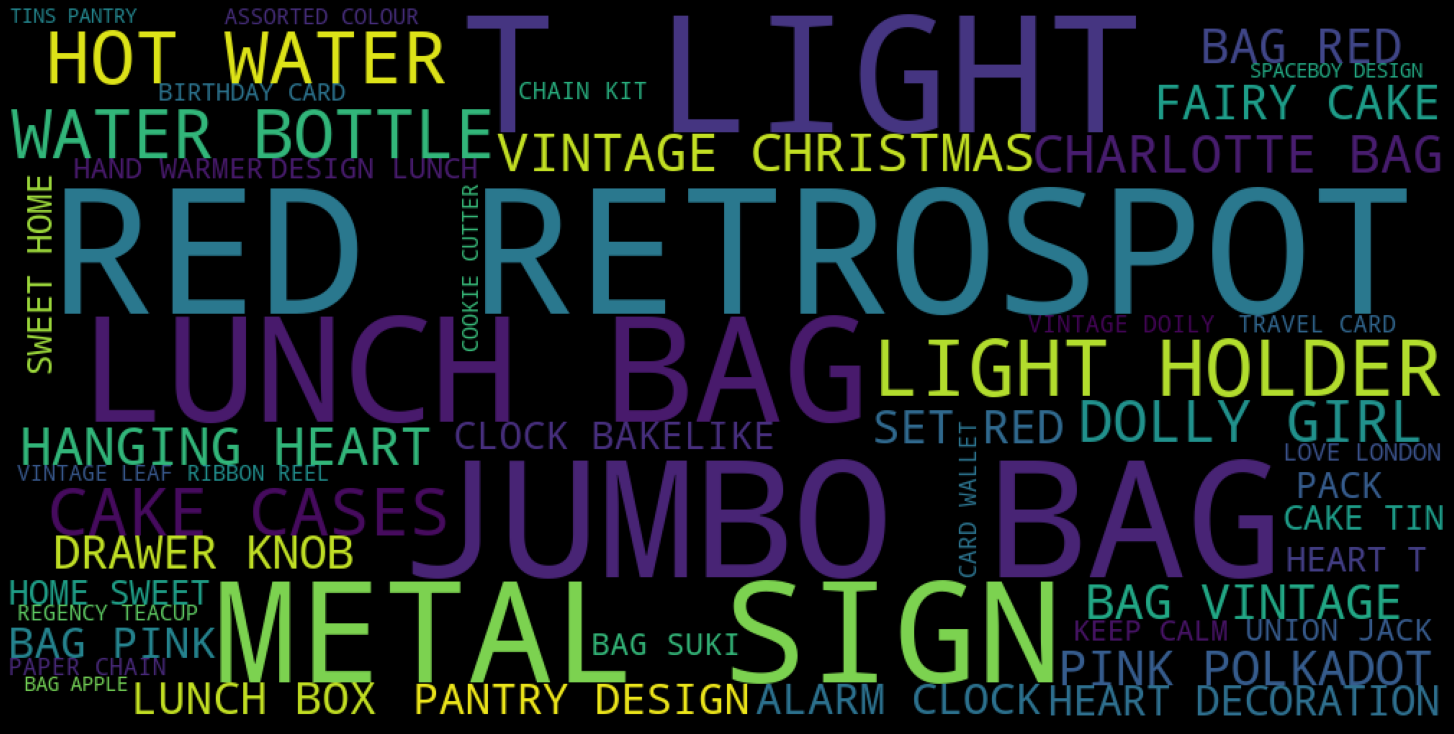

In [13]:
df1 = df.copy()
df1['Description'].fillna("None", inplace = True) 

soup = ' '.join(df1['Description'])

wordcloud = WordCloud(width=1000, height=500,max_words=50)
wordcloud.generate(soup)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

> 이런 느낌의 상품들이 존재합니다.

### 2. 데이터 전처리

- 데이터 타입 확인 및 변환
- 결측치 확인
- 중복값 확인 

#### 1) 데이터 타입 및 결측치 확인

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


> InvoiceDate : object > datetime 으로 변환 

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [16]:
col_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'}) 
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object


In [17]:
col_info = col_info.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'null_counts'}))
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null_counts,0,0,1454,0,0,0,135080,0


In [18]:
col_info = col_info.append(pd.DataFrame(df.isna().sum()/df.shape[0] * 100).T.rename(index={0:'null_prop'}))
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null_counts,0,0,1454,0,0,0,135080,0
null_prop,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


#### 2) 결측치처리

In [19]:
# 결측치 제거 (CustomerID가 없는 경우 의미가 없는 데이터이기 때문에 제거함)
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Shape:', df.shape)

Shape: (406829, 8)


In [20]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### 3) 중복값 확인

In [21]:
df.Country.duplicated().value_counts() # 국적이 중복되지 않는 경우는 37개 존재함

True     406792
False        37
Name: Country, dtype: int64

In [22]:
df['InvoiceNo'].duplicated().value_counts() # 동일한 송장에 여러 주문이 존재함(여러 제품을 주문하는 경우)

True     384639
False     22190
Name: InvoiceNo, dtype: int64

In [23]:
# 중복 데이터 제거
print('Duplicate Entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate Entries: 5225


#### 4) 국가별 주문 수 시각화


In [24]:
df.groupby(['Country'])['InvoiceNo'].count()

Country
Australia                 1258
Austria                    401
Bahrain                     17
Belgium                   2069
Brazil                      32
Canada                     151
Channel Islands            757
Cyprus                     611
Czech Republic              30
Denmark                    389
EIRE                      7475
European Community          61
Finland                    695
France                    8475
Germany                   9480
Greece                     146
Iceland                    182
Israel                     247
Italy                      803
Japan                      358
Lebanon                     45
Lithuania                   35
Malta                      127
Netherlands               2371
Norway                    1086
Poland                     341
Portugal                  1471
RSA                         58
Saudi Arabia                10
Singapore                  229
Spain                     2528
Sweden                     461


In [25]:
country_order = df.groupby(['Country'])['InvoiceNo'].count()
print('No. of countries in the dataframe: {}'.format(len(country_order)))

No. of countries in the dataframe: 37


In [26]:
# 이미 존재하는 지도에 데이터를 매핑시켜 원하는 지도 만들기
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = dict(type='choropleth', 
            locations = country_order.index, # 국가명 데이터  
            locationmode = 'country names', z = country_order, # 국가, 카운트 수 데이터 
            text = country_order.index, colorbar = {'title':'Order no.'},
            colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
            reversescale = False)

In [27]:
layout = dict(title='Number of orders per country',
              geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### 3. 데이터 마이닝

#### 1) 주문 취소 컬럼 추가
- 주문 취소 데이터 삭제
- 원 주문 데이터에 취소 컬럼 추가

In [52]:
df.reset_index(drop=True, inplace=True)

In [55]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [54]:
# 취소 예시 
df[(df['StockCode'] == '23166') & (df['CustomerID'] == '12346')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
37516,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


> StockCode랑 CustomerID가 같으면 같은 고객의 주문, 취소 데이터를 확인할 수 있음
>
> 두 데이터 중 InvoiceDate가 빠른 게 원 주문 데이터

In [68]:
df[df['StockCode'].isin(['23166']) & df['CustomerID'].isin(['12346'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
37516,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


In [71]:
# 원 데이터랑 취소 데이터 추출 
# 수량이 음수인 데이터에서 StockCode와 CustomerID가 같은 원 데이터를 얻고 원 데이터에 새로운 컬럼 추가
# 원 데이터의 개수가 많은 경우 확인 
df2 = df.copy()
idx_chk = []
for idx, row in df2[:1000].iterrows():
  if row['Quantity'] < 0 and row['Description'] != 'Discount':
    test_df_len = len(df2[df2['StockCode'].isin([row['StockCode']]) & df2['CustomerID'].isin([row['CustomerID']])])
    if test_df_len >= 3:
      idx_chk.append(idx)
df2.iloc[idx_chk]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom


In [148]:
df[(df['StockCode'] == '35004C') & (df['CustomerID'] == '15311')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
6750,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
11855,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
18214,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
25143,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
27303,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
37034,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
48630,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


> 위와 같은 경우가 있기 때문에 StockCode와 CustomerID가 같은, 즉 같은 물건을 산 같은 사람의 최초 데이터에 총 주문 수량을 표시하고 나머지 제거




In [ ]:
# Cancel 컬럼 추가
df2 = df.copy()
df2['Cancel'] = 0

remove_idx = []
for idx, row in df2.iterrows():
  if row['Quantity'] < 0 and row['Description'] != 'Discount':
    cancel_chk = df2[df2['StockCode'].isin([row['StockCode']]) & df2['CustomerID'].isin([row['CustomerID']])]
    test_df_len = len(cancel_chk)
    if test_df_len == 1:
      remove_idx.append(idx)
    elif test_df_len == 2:
      remove_idx.append(idx)
      origin_idx = cancel_chk.index[0]
      df2.loc[origin_idx,'Cancel'] = df2.loc[idx,'Quantity']
    else:
      remove_idx.append(idx)
      try:
        origin_idx = cancel_chk[cancel_chk['Quantity'] > 0].index[0]
        df2.loc[origin_idx,'Quantity'] = cancel_chk[cancel_chk['Quantity']>0].sum()['Quantity']
        df2.loc[origin_idx,'Cancel'] = cancel_chk[cancel_chk['Quantity']<0].sum()['Quantity']   
        remain_idx = [i for i in cancel_chk.index if i != origin_idx]
        remove_idx += remain_idx
      except:
        pass
  else:
    continue

In [159]:
# 취소 데이터 삭제
df2.drop(remove_idx, axis=0, inplace=True)

In [160]:
df2.shape

(381957, 9)

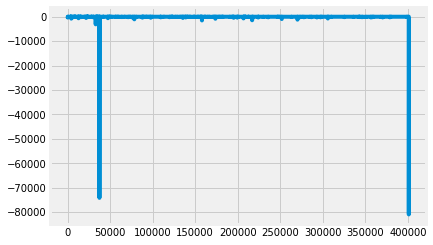

In [166]:
plt.plot(df2.Cancel)

In [169]:
df2.reset_index(drop=True, inplace=True)

#### 2) 구매 금액 컬럼 추가

In [181]:
df2['TotalPrice'] = df2['UnitPrice'] * (df2['Quantity'] + df2['Cancel'])
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


### 4. 키워드 생성

In [196]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [199]:
df_products = pd.DataFrame(df2['Description'].unique()).rename(columns = {0:'Description'})
df_products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3872,"LETTER ""W"" BLING KEY RING"
3873,"LETTER ""Z"" BLING KEY RING"
3874,PINK CRYSTAL SKULL PHONE CHARM
3875,CREAM HANGING HEART T-LIGHT HOLDER


In [204]:
is_noun = lambda pos: pos[:2] == 'NN'  # 명사만 추출하기
def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")  

    keywords_roots  = dict()
    keywords_select = dict()
    category_keys   = []
    count_keywords  = dict()
    icount = 0

    # dataframe[colonne] : Description
    for s in dataframe[colonne]:
        if pd.isnull(s): 
            continue
        
        # 소문자 처리
        lines = s.lower()

        # nltk 토큰화 
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]  # 명사 추출
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t) # 어근 추출

            if racine in keywords_roots:                
                keywords_roots[racine].add(t)  
                count_keywords[racine] += 1              
            else:
                # 어근을 key 로 tokenizing 해서 얻은 명사를 value 로 저장해 준다. ex) {studi : studying}
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
                
    for s in keywords_roots.keys():
        # 같은 어근을 가지는 것들이 2개 이상일 때
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:  # 어근의 길이가 짧은 단어로 선택
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
            
    print("'{}' 컬럼 안의 Keyword 수 : {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [205]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

'Description' 컬럼 안의 Keyword 수 : 1478


In [ ]:
keywords_select.items()

In [ ]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

liste = sorted(list_products, key = lambda x:x[1], reverse = True)


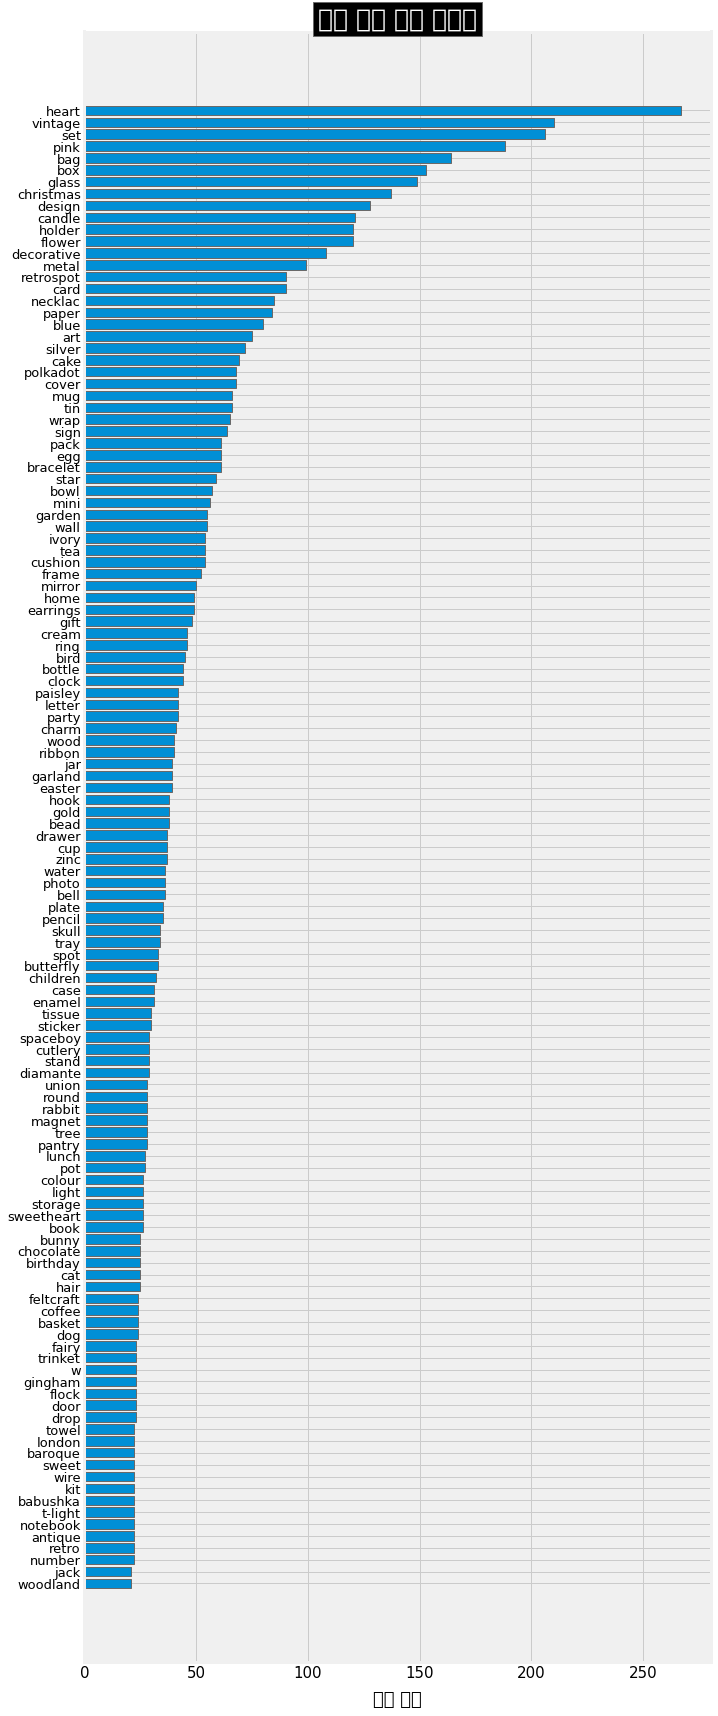

In [216]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 30))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("발생 횟수", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()


plt.title("단어 발생 빈도 그래프",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [218]:
products = df2['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), products))

In [220]:
X.shape

(3877, 1478)

In [226]:
X.head()

,heart,vintage,set,pink,bag,box,glass,christmas,design,candle,...,o,t,z,birdie,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [228]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(products):
    prix = df2[df2['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

### 5. 클러스터링 & PCA
> 상품 군집화 

#### 1) silhouette 점수로 k 구하기

In [229]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("클러스터 개수 =", n_clusters, "silhouette 점수 :", silhouette_avg)

클러스터 개수 = 3 silhouette 점수 : 0.032422128110278184
클러스터 개수 = 4 silhouette 점수 : 0.03139373535435616
클러스터 개수 = 5 silhouette 점수 : 0.03740543042656637
클러스터 개수 = 6 silhouette 점수 : 0.03835103749895012
클러스터 개수 = 7 silhouette 점수 : 0.041005579036698686
클러스터 개수 = 8 silhouette 점수 : 0.04889691994053946
클러스터 개수 = 9 silhouette 점수 : 0.04481042785490908


In [230]:
n_clusters = 8

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [231]:
pd.Series(clusters).value_counts()

1    1227
6     660
4     639
5     399
7     287
3     255
2     214
0     196
dtype: int64

#### 2)PCA

In [232]:
pca = PCA()
pca.fit(X)
pca_samples = pca.transform(X)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.rc('font', family='NanumBarunGothic')
plt.step(range(X.shape[1]), pca.explainead_variance_ratio_.cumsum(), where='mid',
         label='누적된 분산력')

sns.barplot(np.arange(1,X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='개별적인 분산력')

plt.xlim(0, 100)


ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('설명 가능한 분산력', fontsize = 14)
plt.xlabel('주성분 개수', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [235]:
pca = PCA(n_components=50)
matrix = pca.fit_transform(X)
mat = pd.DataFrame(matrix)
mat['cluster'] = pd.Series(clusters)

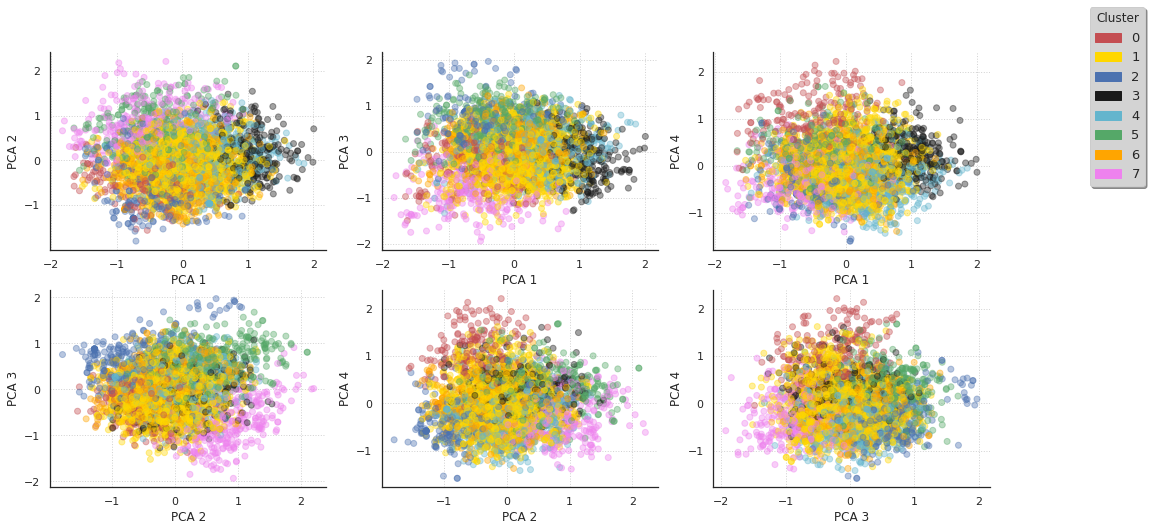

In [243]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g',6:'orange',7:'violet'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(8):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In [245]:
corresp = dict()
for key, val in zip (products, clusters):
    corresp[key] = val 
corresp
df2['categ_product'] = df2.loc[:, 'Description'].map(corresp)

In [247]:
# 상품별 카테고리 컬럼 추가, 값은 가격으로 설정
for i in range(8):
    col = 'categ_{}'.format(i)        
    df_temp = df2[df2['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['Cancel'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df2.loc[:, col] = price_temp
    df2[col].fillna(0, inplace = True)
    

df2[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4','categ_5', 'categ_6','categ_7']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,15.30
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.00
2,536365,CREAM CUPID HEARTS COAT HANGER,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,20.34


### 6. 고객별 데이터 생성

In [249]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,TotalPrice,InvoiceDate_int,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1291191960000000000,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000,1,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,1291191960000000000,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000,1,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000,7,0.0,0.00,0.0,0.0,0.0,0.0,0.0,20.34


In [253]:
temp = df2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price.loc[:, col] = temp.col
basket_price

,CustomerID,InvoiceNo,Basket Price
0,12346,541431,0.00
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52
...,...,...,...
18303,18283,579673,220.31
18304,18283,580872,208.00
18305,18287,554065,765.28
18306,18287,570715,1001.32


In [256]:
for i in range(1):
    col = 'categ_{}'.format(i) 
    temp = df2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    print(temp)
    

      CustomerID InvoiceNo  categ_0
0          12346    541431      0.0
1          12347    537626     39.0
2          12347    542237      0.0
3          12347    549222      0.0
4          12347    556201      0.0
...          ...       ...      ...
18303      18283    579673      0.0
18304      18283    580872      0.0
18305      18287    554065      0.0
18306      18287    570715      0.0
18307      18287    573167      0.0

[18308 rows x 3 columns]


In [264]:
# 고객별 구매하는 상품의 가격 카테고리화
temp = df2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(8):
    col = 'categ_{}'.format(i) 
    temp = df2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price[col] = temp[col]

df2['InvoiceDate_int'] = df2['InvoiceDate'].astype('int64')
temp = df2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df2.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price['InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,InvoiceDate
1,12347,537626,711.79,39.0,390.69,57.40,52.50,0.00,0.00,152.40,19.80,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,0.0,194.55,51.00,35.40,55.90,0.00,110.10,28.44,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,0.0,139.35,123.40,11.70,41.40,6.00,284.40,30.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,0.0,202.72,51.00,32.80,10.20,10.80,54.60,20.40,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,0.0,298.91,145.20,13.00,34.90,0.00,53.30,39.60,2011-08-02 08:48:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...
18295,18283,557956,192.80,0.0,66.21,5.56,16.19,32.14,12.05,54.75,5.90,2011-06-23 19:20:00.000000000
18304,18283,580872,208.00,0.0,52.47,55.93,14.52,20.62,21.58,42.10,0.78,2011-12-06 12:02:00.000000000
18306,18287,570715,1001.32,0.0,295.04,18.72,50.40,91.96,201.60,334.24,9.36,2011-10-12 10:23:00.000000000
18305,18287,554065,765.28,0.0,153.40,0.00,129.30,10.08,30.60,441.90,0.00,2011-05-22 10:39:00.000000000


In [267]:
basket_price.reset_index(drop=True, inplace=True)
basket_price

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,InvoiceDate
0,12347,537626,711.79,39.0,390.69,57.40,52.50,0.00,0.00,152.40,19.80,2010-12-07 14:57:00.000000000
1,12347,542237,475.39,0.0,194.55,51.00,35.40,55.90,0.00,110.10,28.44,2011-01-26 14:29:59.999999744
2,12347,549222,636.25,0.0,139.35,123.40,11.70,41.40,6.00,284.40,30.00,2011-04-07 10:43:00.000000000
3,12347,556201,382.52,0.0,202.72,51.00,32.80,10.20,10.80,54.60,20.40,2011-06-09 13:01:00.000000000
4,12347,562032,584.91,0.0,298.91,145.20,13.00,34.90,0.00,53.30,39.60,2011-08-02 08:48:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...
18169,18283,579673,220.31,0.0,82.68,24.03,11.40,27.10,20.80,54.30,0.00,2011-11-30 12:59:00.000000000
18170,18283,580872,208.00,0.0,52.47,55.93,14.52,20.62,21.58,42.10,0.78,2011-12-06 12:02:00.000000000
18171,18287,554065,765.28,0.0,153.40,0.00,129.30,10.08,30.60,441.90,0.00,2011-05-22 10:39:00.000000000
18172,18287,570715,1001.32,0.0,295.04,18.72,50.40,91.96,201.60,334.24,9.36,2011-10-12 10:23:00.000000000


In [273]:
# 고객별 통계 확인
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(8):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum()


transactions_per_user.reset_index(drop = False, inplace = True)
transactions_per_user.sort_values('CustomerID', ascending = True)

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7
0,12347,7,224.82,1294.32,615.714286,4310.00,56.4,2038.88,612.00,278.00,232.60,49.28,819.70,223.14
1,12348,4,227.44,892.80,449.310000,1797.24,0.0,360.00,63.60,63.60,454.28,0.00,684.40,171.36
2,12349,1,1757.55,1757.55,1757.550000,1757.55,47.6,758.23,101.49,19.80,58.62,318.00,217.76,236.05
3,12350,1,334.40,334.40,334.400000,334.40,0.0,115.60,19.80,17.70,39.10,0.00,142.20,0.00
4,12352,8,40.00,1506.00,381.426250,3051.41,66.9,4784.58,53.50,138.65,20.80,44.10,291.14,151.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,18280,1,180.60,180.60,180.600000,180.60,0.0,165.75,14.85,0.00,0.00,0.00,0.00,0.00
4323,18281,1,80.82,80.82,80.820000,80.82,0.0,49.20,0.00,0.00,15.12,0.00,16.50,0.00
4324,18282,2,77.84,98.76,88.300000,176.60,0.0,98.80,17.70,13.00,22.01,5.04,22.95,0.00
4325,18283,16,1.95,307.05,127.845625,2045.53,13.7,652.39,282.83,102.08,224.86,195.77,514.68,59.22


In [287]:
# 고객 구매 시기 확인
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days) 
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,56.4,2038.88,612.00,278.00,232.60,49.28,819.70,223.14,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,0.0,360.00,63.60,63.60,454.28,0.00,684.40,171.36,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,47.6,758.23,101.49,19.80,58.62,318.00,217.76,236.05,18,18
3,12350,1,334.40,334.40,334.400000,334.40,0.0,115.60,19.80,17.70,39.10,0.00,142.20,0.00,310,310
4,12352,8,40.00,1506.00,381.426250,3051.41,66.9,4784.58,53.50,138.65,20.80,44.10,291.14,151.40,36,296


### 7. 모델링

#### 1) 라벨링하기




In [343]:
# 데이터 스케일링

X = transactions_per_user.copy()
X.drop(['CustomerID'], axis=1, inplace=True)
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [344]:
# PCA

pca = PCA()
pca.fit(scaled_X)
pca_samples = pca.transform(scaled_X)

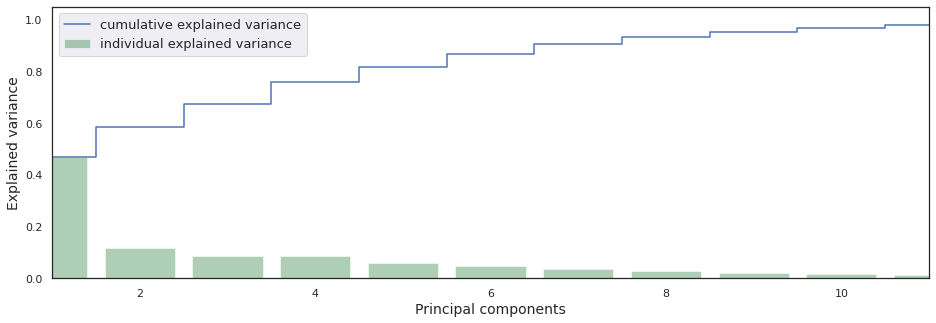

In [345]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

> cumulative explained variance : 각 구성 요소가 얼마나 중요한지 평가, 
>
> 첫 번째 값이 전체 분산의 약 50% 차지
>
> 적절한 차원 : 5


In [346]:
for i in range(3,11):
  kmeans = KMeans(init='k-means++', n_clusters = i, n_init=100)
  kmeans.fit(scaled_X)
  clusters_clients = kmeans.predict(scaled_X)
  silhouette_avg = silhouette_score(scaled_X, clusters_clients)
  print('n_cluster : ', i)
  print('silhouette score: {:<.3f}'.format(silhouette_avg))

n_cluster :  3
silhouette score: 0.883
n_cluster :  4
silhouette score: 0.263
n_cluster :  5
silhouette score: 0.340
n_cluster :  6
silhouette score: 0.352
n_cluster :  7
silhouette score: 0.358
n_cluster :  8
silhouette score: 0.358
n_cluster :  9
silhouette score: 0.360
n_cluster :  10
silhouette score: 0.367


In [374]:
n_clusters = 10
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_X)
clusters_clients = kmeans.predict(scaled_X)
silhouette_avg = silhouette_score(scaled_X, clusters_clients)

In [375]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no. of customers']).T

,2,6,0,4,5,7,3,8,1,9
no. of customers,1608,1487,993,188,30,12,5,2,1,1


In [376]:
pca = PCA(n_components=5)
X_selected = pca.fit_transform(scaled_X)
mat = pd.DataFrame(X_selected)
mat['cluster'] = pd.Series(clusters_clients)

In [377]:
mat.head()

,0,1,2,3,4,cluster
0,1.095228,-0.240372,-0.368572,0.102867,0.239397,2
1,0.189572,-0.267501,-0.450985,0.592949,-0.069193,2
2,0.535041,5.732620,-0.755192,-0.988273,0.722555,4
3,-0.680442,0.195351,-0.041554,2.146484,-0.245966,0
4,0.576661,-0.716444,-0.147264,-0.090891,0.298151,2


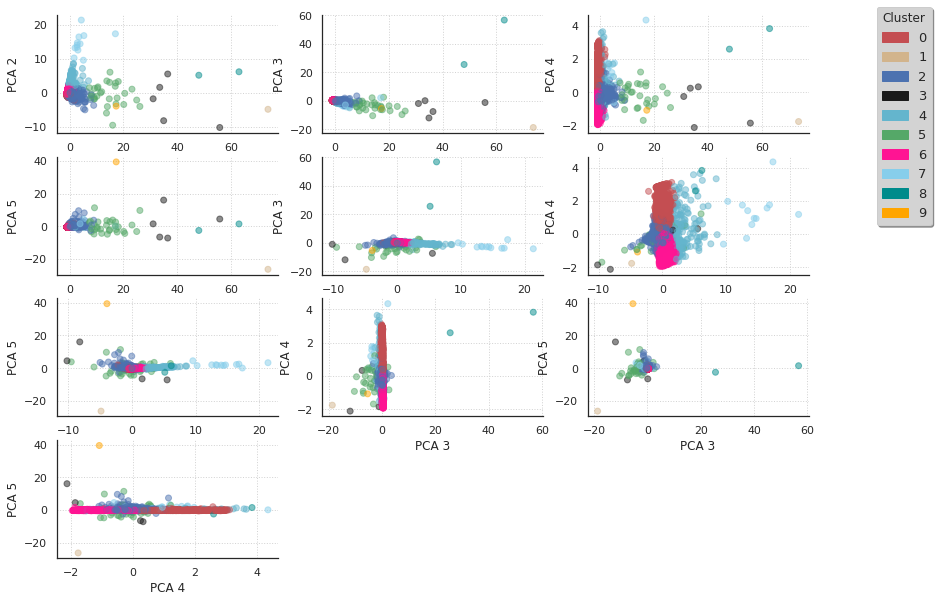

In [378]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(5):
    for iy in range(ix+1, 5):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

In [379]:
X.loc[:, 'cluster'] = clusters_clients

#### 2) 모델링

In [380]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    # train on the x_train and y_train data
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    # predict/validate on the held-out data
    def predict(self, x):
        return self.clf.predict(x)
    
    # hyperparameter tuning using GridsearchCV
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
    
    # fit after tuning
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
    
    # predict
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [391]:
X1 = X.copy()
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5', 'categ_6', 'categ_7','LastPurchase','FirstPurchase']
Y = X1['cluster']
X = X1[columns]

In [392]:
Y.value_counts()

2    1608
6    1487
0     993
4     188
5      30
7      12
3       5
8       2
1       1
9       1
Name: cluster, dtype: int64

In [393]:
X.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,LastPurchase,FirstPurchase
0,615.714286,56.4,2038.88,612.00,278.00,232.60,49.28,819.70,223.14,2,367
1,449.310000,0.0,360.00,63.60,63.60,454.28,0.00,684.40,171.36,75,358
2,1757.550000,47.6,758.23,101.49,19.80,58.62,318.00,217.76,236.05,18,18
3,334.400000,0.0,115.60,19.80,17.70,39.10,0.00,142.20,0.00,310,310
4,381.426250,66.9,4784.58,53.50,138.65,20.80,44.10,291.14,151.40,36,296


In [394]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=2002)

In [395]:
X_train.shape, Y_train.shape

((3461, 11), (3461,))

In [396]:
X_test.shape, Y_test.shape

((866, 11), (866,))

SVC

In [397]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [398]:
svc.grid_fit(X = X_train, Y = Y_train)

In [399]:
svc.grid_predict(X_test, Y_test)

Precision: 83.95 % 


Linear Regressor

In [400]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)

# fit on training data
lr.grid_fit(X = X_train, Y = Y_train)

# predict on test data
lr.grid_predict(X_test, Y_test)

Precision: 77.48 % 


k-Nearest Neighbors

In [401]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)

# fit on training data
knn.grid_fit(X = X_train, Y = Y_train)

# predict on test data
knn.grid_predict(X_test, Y_test)

Precision: 90.76 % 


Decision Tree

In [402]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)

# fit on training data
tr.grid_fit(X = X_train, Y = Y_train)

# predict on test data
tr.grid_predict(X_test, Y_test)

Precision: 91.11 % 


Random Forest

In [403]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}

rf.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
rf.grid_fit(X = X_train, Y = Y_train)

# predict on test data
rf.grid_predict(X_test, Y_test)

Precision: 96.42 % 


AdaBoost Classifier

In [404]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
ada.grid_fit(X = X_train, Y = Y_train)

# predict on test data
ada.grid_predict(X_test, Y_test)

Precision: 67.67 % 


Gradient Boosting Classifier

In [405]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
gb.grid_fit(X = X_train, Y = Y_train)

# predict on test data
gb.grid_predict(X_test, Y_test)

Precision: 96.77 % 


Voting Classifier

In [406]:
# random forest classifier best params
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)

# gradient boosting classifier best params
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)

# support vector classifier best params
svc_best = svm.LinearSVC(**svc.grid.best_params_)

# decision tree classifier best params
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)

# k-nearest neighbor classifier best params
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)

# logistics regression best params
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [407]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('lr', lr_best)], voting='soft')
votingC = votingC.fit(X_train, Y_train)
predictions = votingC.predict(X_test)

print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 96.42 % 


> 고객을 10가지 군집으로 군집화 진행하였고 각각 고객들의 특성은 데이터 feature에서 확인할 수 있음